In [20]:
# ✅ BETTER: LightGBM with proper time-series validation
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

class BetterFeatureEngineer:
    def __init__(self, threshold=2.0):
        self.threshold = threshold
        self.scaler = RobustScaler()
        self.feature_cols = []
        self.target_col = f'target_gt_{int(threshold)}'
        self.is_fitted = False

    def create_features(self, df):
        df = df.copy()
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.sort_values('timestamp').reset_index(drop=True)

        # Cap outliers
        p99 = df['multiplier'].quantile(0.99)
        p01 = df['multiplier'].quantile(0.01)
        df['m'] = df['multiplier'].clip(p01, p99)

        # Lag features
        for lag in [1, 2, 3, 5]:
            df[f'lag_{lag}'] = df['m'].shift(lag)

        # Rolling stats
        for w in [5, 10, 20]:
            df[f'roll_mean_{w}'] = df['m'].rolling(w, min_periods=w).mean()
            df[f'roll_std_{w}'] = df['m'].rolling(w, min_periods=w).std()
            df[f'roll_min_{w}'] = df['m'].rolling(w, min_periods=w).min()
            df[f'roll_max_{w}'] = df['m'].rolling(w, min_periods=w).max()

        # EMA
        for span in [5, 10]:
            df[f'ema_{span}'] = df['m'].ewm(span=span).mean()

        # Volatility ratio
        df['vol_ratio'] = df['roll_std_5'] / (df['roll_std_20'] + 1e-8)

        # Inter-arrival time of high events
        df['is_high'] = (df['m'] > self.threshold).astype(int)
        df['time_since_last_high'] = df['is_high'].replace(0, np.nan).fillna(method='ffill').apply(lambda x: np.nan if pd.isna(x) else 0)
        # Actually compute time since last high properly
        df['time_since_last_high'] = (
            df['is_high'].shift(1).fillna(0)
            .groupby((df['is_high'].shift(1) != df['is_high'].shift(1).shift(1)).cumsum())
            .cumcount() + 1
        )
        df['time_since_last_high'] = df['time_since_last_high'].where(df['is_high'].shift(1) == 0, 0)

        # Probability in rolling windows
        for w in [10, 20, 50]:
            df[f'prob_high_{w}'] = df['is_high'].rolling(w, min_periods=w).mean()

        # Autocorrelation approx
        df['ac_lag1'] = df['m'].autocorr(lag=1)
        # But autocorr is global; better to use lag diff
        df['diff_lag1'] = df['m'] - df['lag_1']
        df['diff_lag2'] = df['lag_1'] - df['lag_2']

        # TARGET: next multiplier > threshold?
        df[self.target_col] = (df['m'].shift(-1) > self.threshold).astype(int)

        # Clean up
        exclude = ['timestamp', 'multiplier', 'm', 'is_high']
        self.feature_cols = [c for c in df.columns if c not in exclude and c != self.target_col]

        return df.dropna().reset_index(drop=True)

    def fit_transform(self, df):
        df_feat = self.create_features(df)
        X = df_feat[self.feature_cols].values
        y = df_feat[self.target_col].values
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        X_scaled = self.scaler.fit_transform(X)
        self.is_fitted = True
        return X_scaled, y, df_feat

    def transform(self, df):
        df_feat = self.create_features(df)
        X = df_feat[self.feature_cols].values
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        X_scaled = self.scaler.transform(X)
        return X_scaled, df_feat[self.target_col].values


def train_lgbm_model(df, threshold=2.0, n_splits=5):
    fe = BetterFeatureEngineer(threshold=threshold)
    X, y, df_full = fe.fit_transform(df)

    # TimeSeriesSplit for proper validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    models = []
    scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Handle class imbalance with scale_pos_weight
        pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

        model = lgb.LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=pos_weight,
            objective='binary',
            metric='auc',
            random_state=42,
            verbose=-1
        )

        # Use callbacks for early stopping (LightGBM 3.0+)
        # Fallback to old API if callbacks not supported
        try:
            model.fit(
                X_train, y_train, 
                eval_set=[(X_val, y_val)], 
                callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
            )
        except (TypeError, AttributeError):
            # Fallback to old API (LightGBM < 3.0)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_val, y_val)], 
                early_stopping_rounds=20, 
                verbose=False
            )
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred_proba)
        ll = log_loss(y_val, y_pred_proba)
        brier = brier_score_loss(y_val, y_pred_proba)

        scores.append({'fold': fold, 'auc': auc, 'logloss': ll, 'brier': brier})
        models.append(model)

        print(f"Fold {fold}: AUC={auc:.4f}, LogLoss={ll:.4f}, Brier={brier:.4f}")

    # Aggregate
    avg_auc = np.mean([s['auc'] for s in scores])
    avg_ll = np.mean([s['logloss'] for s in scores])
    avg_brier = np.mean([s['brier'] for s in scores])

    print(f"\n✅ Final CV: AUC={avg_auc:.4f}, LogLoss={avg_ll:.4f}, Brier={avg_brier:.4f}")

    # Retrain on full data
    pos_weight = np.sum(y == 0) / np.sum(y == 1)
    final_model = lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        scale_pos_weight=pos_weight,
        random_state=42,
        verbose=-1
    )
    final_model.fit(X, y)

    return {
        'model': final_model,
        'feature_engineer': fe,
        'cv_scores': scores,
        'metrics': {
            'cv_auc': avg_auc,
            'cv_logloss': avg_ll,
            'cv_brier': avg_brier
        }
    }


def predict_probability(model_dict, df):
    fe = model_dict['feature_engineer']
    if not fe.is_fitted:
        raise ValueError("Feature engineer not fitted!")

    # Get latest row
    df_feat = fe.create_features(df)
    if len(df_feat) == 0:
        return None

    X = df_feat[fe.feature_cols].iloc[[-1]].values
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    X_scaled = fe.scaler.transform(X)
    prob = model_dict['model'].predict_proba(X_scaled)[0, 1]
    return float(prob)



In [21]:
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def calibrate_model(model_dict, df):
    """
    Calibrate model using isotonic regression on validation folds.
    Returns a calibrated model dict.
    """
    fe = model_dict['feature_engineer']
    X, y, df_full = fe.fit_transform(df)  # use full data or a holdout set

    # Use last 20% as holdout for calibration (not used in training)
    split_idx = int(0.8 * len(X))
    X_cal, y_cal = X[split_idx:], y[split_idx:]

    # Get raw probabilities
    raw_proba = model_dict['model'].predict_proba(X_cal)[:, 1]

    # Fit isotonic calibrator
    isotonic = IsotonicRegression(out_of_bounds='clip')
    isotonic.fit(raw_proba, y_cal)

    # Evaluate calibration
    calibrated_proba = isotonic.predict(raw_proba)
    print(f"📈 Calibration: Raw Brier={brier_score_loss(y_cal, raw_proba):.4f}, "
          f"Calibrated Brier={brier_score_loss(y_cal, calibrated_proba):.4f}")

    return {
        'model': model_dict['model'],
        'feature_engineer': fe,
        'calibrator': isotonic,
        'metrics': model_dict['metrics'],
        'cv_scores': model_dict.get('cv_scores', [])
    }

def predict_calibrated_probability(model_dict, df):
    fe = model_dict['feature_engineer']
    df_feat = fe.create_features(df)
    if len(df_feat) == 0:
        return None

    X = df_feat[fe.feature_cols].iloc[[-1]].values
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    X_scaled = fe.scaler.transform(X)
    raw_prob = model_dict['model'].predict_proba(X_scaled)[0, 1]
    calibrated_prob = model_dict['calibrator'].predict([raw_prob])[0]
    return float(np.clip(calibrated_prob, 0.0, 1.0))

def plot_calibration(model_dict, df):
    fe = model_dict['feature_engineer']
    X, y, _ = fe.fit_transform(df)
    split_idx = int(0.8 * len(X))
    X_cal, y_cal = X[split_idx:], y[split_idx:]

    raw_proba = model_dict['model'].predict_proba(X_cal)[:, 1]
    calib_proba = model_dict['calibrator'].predict(raw_proba)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Raw
    frac_raw, prob_raw = calibration_curve(y_cal, raw_proba, n_bins=10)
    ax[0].plot(prob_raw, frac_raw, "s-", label="Model")
    ax[0].plot([0, 1], [0, 1], "k:", label="Perfect")
    ax[0].set_title("Raw Calibration")
    ax[0].set_xlabel("Predicted Probability")
    ax[0].set_ylabel("True Frequency")
    ax[0].legend()

    # Calibrated
    frac_cal, prob_cal = calibration_curve(y_cal, calib_proba, n_bins=10)
    ax[1].plot(prob_cal, frac_cal, "s-", color='red', label="Calibrated")
    ax[1].plot([0, 1], [0, 1], "k:")
    ax[1].set_title("Calibrated (Isotonic)")
    ax[1].set_xlabel("Predicted Probability")
    ax[1].set_ylabel("True Frequency")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# ================ STRATEGY SIMULATION ================

def simulate_kelly_strategy(df, model_dict, cashout_multiplier=2.0, kelly_fraction=0.5, min_prob=0.55, initial_balance=100.0):
    """
    Simulate betting using Kelly Criterion.
    
    Args:
        df: full data (must include future multipliers!)
        model_dict: calibrated model
        cashout_multiplier: e.g., 2.0
        kelly_fraction: 0.5 = half-Kelly (safer)
        min_prob: only bet if calibrated prob >= this
        initial_balance: starting bankroll
    """
    balance = initial_balance
    balances = [balance]
    bets = []
    outcomes = []

    # We need to predict BEFORE seeing the next multiplier
    # So iterate up to second-to-last row
    for i in range(len(df) - 1):
        # Use data up to index i to predict i+1
        history = df.iloc[:i+1].copy()
        if len(history) < 50:  # warm-up
            balances.append(balance)
            continue

        prob = predict_calibrated_probability(model_dict, history)
        if prob is None or prob < min_prob:
            # No bet
            balances.append(balance)
            bets.append(0.0)
            outcomes.append(0)
            continue

        # Kelly bet fraction
        p = prob
        q = 1 - p
        b = cashout_multiplier - 1  # net odds (profit per \$1)
        kelly_f = (b * p - q) / b if b > 0 else 0
        kelly_f = max(0, min(kelly_f, 1))  # clamp [0,1]
        bet_fraction = kelly_fraction * kelly_f
        bet_amount = bet_fraction * balance

        # Did we win? (next multiplier > cashout?)
        next_mult = df['multiplier'].iloc[i+1]
        win = next_mult >= cashout_multiplier

        if win:
            balance += bet_amount * b
            outcomes.append(1)
        else:
            balance -= bet_amount
            outcomes.append(0)

        bets.append(bet_amount)
        balances.append(balance)

        if balance <= 0.01:
            print(f"⚠️ Ruin at step {i}")
            break

    # Metrics
    total_return = balance / initial_balance - 1
    sharpe = np.mean(np.diff(balances)) / (np.std(np.diff(balances)) + 1e-8) if len(balances) > 1 else 0
    max_drawdown = (np.maximum.accumulate(balances) - balances).max() / np.maximum.accumulate(balances).max()

    print(f"\n🎯 Strategy Simulation Results:")
    print(f"   Final Balance: ${balance:.2f} (Return: {total_return:.2%})")
    print(f"   Sharpe Ratio: {sharpe:.3f}")
    print(f"   Max Drawdown: {max_drawdown:.2%}")
    print(f"   Total Bets: {sum(1 for b in bets if b > 0)} / {len(bets)}")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(balances, label='Bankroll')
    plt.axhline(initial_balance, color='k', linestyle='--', label='Start')
    plt.title("Kelly Betting Simulation (Fractional)")
    plt.xlabel("Time Step")
    plt.ylabel("Balance ($)")
    plt.legend()
    plt.show()

    return {
        'final_balance': balance,
        'return_pct': total_return,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'balances': balances,
        'bets': bets
    }

In [22]:
import os
import pandas as pd

def load_multiplier_data(data_path='../data/aviator_payouts_global.csv'):
    """
    Load multiplier data from CSV.
    Expected columns: 'timestamp', 'multiplier'
    """
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found: {data_path}")
    
    print(f"📂 Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    
    # Validate required columns
    required = {'timestamp', 'multiplier'}
    if not required.issubset(df.columns):
        raise ValueError(f"Missing required columns. Got: {list(df.columns)}, Need: {required}")
    
    # Parse timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Ensure multiplier is numeric
    df['multiplier'] = pd.to_numeric(df['multiplier'], errors='coerce')
    
    # Drop invalid rows
    initial_len = len(df)
    df = df.dropna(subset=['timestamp', 'multiplier']).reset_index(drop=True)
    final_len = len(df)
    
    if final_len == 0:
        raise ValueError("No valid data after cleaning!")
    
    print(f"✅ Loaded {final_len} rows (dropped {initial_len - final_len} invalid rows)")
    print(f"   Time range: {df['timestamp'].min()} → {df['timestamp'].max()}")
    print(f"   Multiplier range: {df['multiplier'].min():.3f} → {df['multiplier'].max():.3f}")
    
    return df

📂 Loading data from ../data/aviator_payouts_global.csv...
✅ Loaded 10956 rows (dropped 0 invalid rows)
   Time range: 2025-12-10 19:32:35 → 2025-12-14 18:43:57
   Multiplier range: 1.000 → 6711.930
Fold 0: AUC=0.5151, LogLoss=0.6927, Brier=0.2498
Fold 1: AUC=0.5149, LogLoss=0.6924, Brier=0.2496
Fold 2: AUC=0.5104, LogLoss=0.6924, Brier=0.2496
Fold 3: AUC=0.5238, LogLoss=0.6957, Brier=0.2511
Fold 4: AUC=0.5141, LogLoss=0.6919, Brier=0.2494

✅ Final CV: AUC=0.5157, LogLoss=0.6930, Brier=0.2499
📈 Calibration: Raw Brier=0.1950, Calibrated Brier=0.1151


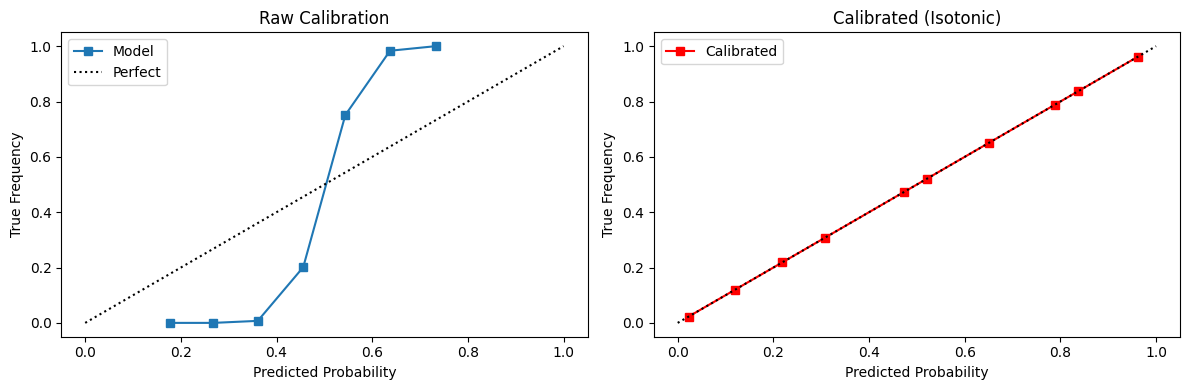


🔮 Calibrated P(next > 2.0) = 0.1214

🎯 Strategy Simulation Results:
   Final Balance: $nan (Return: nan%)
   Sharpe Ratio: nan
   Max Drawdown: nan%
   Total Bets: 3291 / 10906


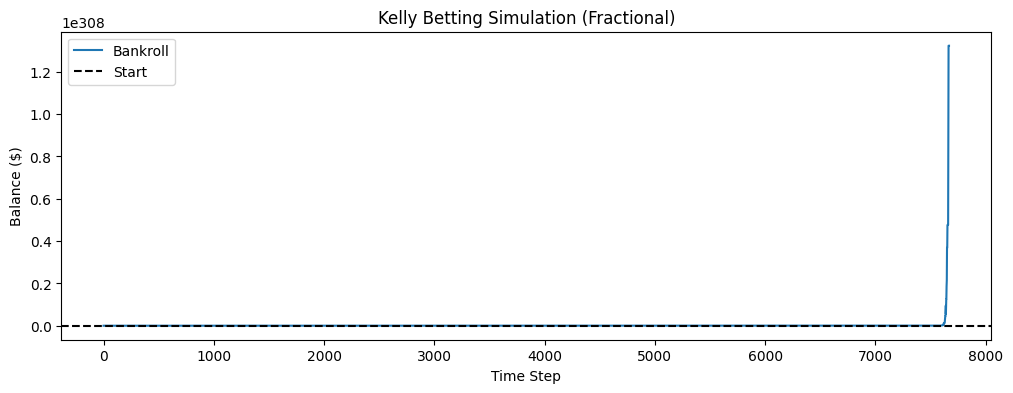

In [23]:

try:
    df = load_multiplier_data()
except Exception as e:
    print(f"❌ Error loading data: {e}")
    exit(1)

# Ensure enough data
if len(df) < 500:
    print(f"⚠️ Warning: Only {len(df)} samples. Model may not generalize.")

# Sort just in case
df = df.sort_values('timestamp').reset_index(drop=True)

# Rest of pipeline: train → calibrate → simulate
model_dict = train_lgbm_model(df, threshold=2.0, n_splits=5)
model_calib = calibrate_model(model_dict, df)
plot_calibration(model_calib, df)

prob_cal = predict_calibrated_probability(model_calib, df)
print(f"\n🔮 Calibrated P(next > 2.0) = {prob_cal:.4f}")

# Run simulation (only if enough data)
if len(df) > 1000:
    simulate_kelly_strategy(
        df=df,
        model_dict=model_calib,
        cashout_multiplier=2.0,
        kelly_fraction=0.5,
        min_prob=0.55,
        initial_balance=100.0
    )
else:
    print("⏭️ Skipping strategy simulation (insufficient data)")